<h1 style="text-align: center;">РАСПОЗНАВАНИЕ ТОКСИЧНЫХ КОММЕНТАРИЕВ</h1>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Импорт-библиотек-и-определение-констант" data-toc-modified-id="Импорт-библиотек-и-определение-констант-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек и определение констант</a></span></li><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обзор и подготовка данных</a></span></li><li><span><a href="#Конструирование-признаков" data-toc-modified-id="Конструирование-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Конструирование признаков</a></span></li><li><span><a href="#Формирование-выборок" data-toc-modified-id="Формирование-выборок-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Формирование выборок</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

### Постановка задачи
Обучите модель классифицировать комментарии на позитивные и негативные с метрикой качества *F1* не меньше 0.75. 
 
**Ход решения:**
 - загрузите и изучите данные, 
 - подготовьте данные, 
 - обучите разные модели с различными гиперпараметрами, 
 - проверьте лучшую модель на тестовой выборке и сделайте выводы.

### Описание данных 
В вашем распоряжении набор данных с разметкой о токсичности правок.

**Признаки:**
 - text - текст комментария. 

**Целевой признак:**
 - toxic — токсичен комментарий или нет.
 
## Импорт библиотек и определение констант

In [55]:
!pip install pandarallel

In [56]:
import gc 
import pandas as pd
import matplotlib.pyplot as plt
import re 
import numpy as np 
import spacy

from tqdm.notebook import tqdm

from pandarallel import pandarallel

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.linear_model import (
    LogisticRegression, 
    SGDClassifier
)
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    f1_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    precision_recall_curve
)

from catboost import CatBoostClassifier

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#фиксируем:
# - путь к данным
PATH = '/datasets/toxic_comments.csv'
# - целевой признак и признаки объекта
TARGET = 'toxic' 
FEATURES = ['corpus', 'word_count', 'char_count']
# - признаки для векторизации и масштабирования
FTS_TO_VECTORIZE = 'corpus'
FTS_TO_SCALE = ['word_count', 'char_count']
# - параметр random state
SEED = 3841

## Обзор и подготовка данных
Поместим данные в DataFrame. На примере нескольких строк оценим датасет визульно. Посмотрим на общую информацию.

In [4]:
df = pd.read_csv(PATH)
df.sample(10)

,Unnamed: 0,text,toxic
136032,136170,"""\n\n Rivalry with Caltech \n\nThis section se...",0
44512,44565,userbox \n\nI made a small edit to one of your...,0
122819,122925,Illicit Use Slang Terms \n\nI am thinking thi...,0
63974,64041,http://www.theguardian.com/lifeandstyle/wordof...,0
24017,24037,"""icon|w|or|d}} removes the cumbersome """"IPA"""" ...",0
32520,32560,Hope this tis is no offense to either of yahs....,0
125698,125829,Thank you. This is not esplained on the page ...,0
153428,153585,Spelling\nIsn't the word spelled macuahuitl? O...,0
57778,57841,Richard Suhre is not a local...He was a transp...,0
14679,14695,"""\n I wouldn't go so far as to say that they a...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Типы данных, определены верно. Данные интерпретированы корректно. Пропуски отсутствуют. Имеется неинформативный признак `Unnamed: 0`. В остальном, предобработка данных не требуется.

Удалим неинформативный признак.

In [6]:
df = df.drop('Unnamed: 0', axis=1)

Оценим соотношение классов:
 - в абсолютных значениях

In [7]:
df[TARGET].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

- и относительных значениях

In [8]:
df[TARGET].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Примерно 10% комментариев - токсичны (класс 1), оставшиеся 90% - не токсичны (класс 0). Т.о., нам предстоит решить задачу бинарной классификации в условиях дисбаланса классов. 

## Конструирование признаков
Лемматизировав содержимое столбца `text`, получим новый признак `corpus`. Дабы повысить качество прогноза добавим два дополнительных признака:
 - `word_count` - количество слов в комментарии,
 - `char_count` - количество символов в комментарии. 

Опишем помогающую функцию.

In [71]:
def make_features(row, processor):
    """Возвращает строку DataFrame с тремя новыми признаками:
     - corpus - лемматизированный, приведенный к нижнему 
    регистру текст, содержащий только буквенные символы,
     - word_count - количество слов в тексте,
     - char_count - количество символов в тексте
    АРГУМЕНТЫ:
    row -- строка DataFrame с текстом для очистки и лемматизации
    processor -- лемматизатор
    """    
    corpus = ''
    word_cnt = 0
    char_cnt = 0
    tokens = processor(row['text'])
    
    for t in tokens:
        lemma = t.lemma_.lower()
        if lemma.isalpha():
            if corpus == '':
                corpus = lemma
            else:
                corpus = corpus + ' ' + lemma
            word_cnt += 1
        
    char_cnt = len(corpus)
    row['corpus'] = corpus
    row['word_count'] = word_cnt
    row['char_count'] = char_cnt    
    return row

In [10]:
#инициализируем лемматизатор
nlprocessor = spacy.load(
    'en_core_web_sm', 
    disable=['parser', 'ner']
)
#инициализируем индикатор прогресса
tqdm.pandas(desc="progress")
#создаем новые признаки
df = df.progress_apply(make_features, axis=1, args=(nlprocessor, ))

progress:   0%|          | 0/159292 [00:00<?, ?it/s]

Проверим результат.

In [11]:
df.sample(10)

,text,toxic,corpus,word_count,char_count
13734,Yes! I m pretty excited for it.,0,yes i m pretty excited for it,7,29
84642,"""\nI agree. My only objection would be an att...",0,i agree my only objection would be an attempt ...,72,376
88356,"sweet, I love them. Keep it up!",0,sweet i love they keep it up,7,28
137673,"""\n\n Categories \n\nHey.. these categories yo...",0,category hey these category you be add importa...,104,562
106973,"""\n\n Hmm. \n\nNot one lousy source, all of th...",0,hmm not one lousy source all of they deny reli...,145,810
113477,Why is fatima put as winner and anya as runner...,0,why be fatima put as winner and anya as runner...,24,110
19075,It's not just the spokesman- the president of ...,0,it be not just the the president of the dlm be...,28,136
74088,No problem at. (talk • contribs • logs),0,no problem at talk contrib log,6,30
119261,Death \n\nCan someone at to the lead that he d...,0,death can someone at to the lead that he die t...,11,50
38602,"Good grief John, you were willing to introduce...",0,good grief john you be willing to introduce th...,39,219


Признаки сформированы корректно.

Проверим данные на неинформативные комментарии с нулевым количеством символов.

In [12]:
df[df['char_count'] == 0].sample(10)

,text,toxic,corpus,word_count,char_count
17280,~ \n\n68.193.147.157,0,,0,0
147397,http://www.world-pyramids.com/atr/usa/monkmoun...,0,,0,0
98154,http://goproxing.biz 82.103.128.115,0,,0,0
70026,207.181.198.184 Crescat100,0,,0,0
104572,"800 Club|800]] 07:29, 20",0,,0,0
93421,{{unblock|yo,0,,0,0
68350,http://en.wikipedia.org/wiki/Towns_in_the_Form...,0,,0,0
106701,http://en.wikipedia.org/wiki/Wikipedia:ELYES,0,,0,0
93873,http://wikipediawehaveaproblem.com/evidence-of...,0,,0,0
41556,[ ]\nhttp://www.smallholder.co.uk/news/87898...,0,,0,0


Удалим неинформативные строки и проверим результат.

In [13]:
df = df[df['char_count'] > 0] 
print(
    'Кол-во неинформативных строк:', 
    df[df['char_count'] == 0].shape[0]
)    

Кол-во неинформативных строк: 0


## Формирование выборок
Нам предстоит решить задачу бинарной классификации в условиях дисбаланса классов. Следовательно, соотношение классов в основном датасете должно воспроизводиться в выборках. Для этого сформируем стратифицированные обучающую и тестовую выборки. 

In [16]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

Проверим размер выборок и соотношение классов в них.

In [17]:
print('Размер выборок:',
     '\n - обучающая (признаки):', X_train.shape,
     '\n - обучающая (целевой признак):', y_train.shape,
     '\n - тестовая (признаки):', X_test.shape,
     '\n - тестовая (целевой признак):', y_test.shape)

Размер выборок: 
 - обучающая (признаки): (119428, 3) 
 - обучающая (целевой признак): (119428,) 
 - тестовая (признаки): (39810, 3) 
 - тестовая (целевой признак): (39810,)


In [18]:
#выясняем соотношение классов в выборках
balance_df = y.value_counts(normalize=True)
balance_train = y_train.value_counts(normalize=True)
balance_test = y_test.value_counts(normalize=True)
#формируем сводную таблицу
comparsion = pd.concat([balance_df, balance_train, balance_test], axis=1)
comparsion.columns = ['dataframe', 'train_sample', 'test_sample']
comparsion

,dataframe,train_sample,test_sample
0,0.89836,0.898357,0.898367
1,0.10164,0.101643,0.101633


Выборки сформированы корректно.
## Моделирование
На обучающей выборке, с кросс-валидацией и метрикой качества F1:
 - формируем вектор признаков TF-IDF,
 - масштабируем признаки `word_count`, `char_count`, 
 - ищем оптимальные гиперпараметры для моделей: 
     - LogisticRegression, 
     - SGDClassifier,
     - CatBoostClassifier.

Дисбаланс классов компенсируем параметром `class_weight = 'balanced'`.

In [79]:
#готовим стоп-слова
s_words = set(stopwords.words('english'))
#готовим ColumnTransformer из 
#TfidfVectorizer и MinMaxScaler
col_transformer = ColumnTransformer(
    [(
        'vectorizer', 
        TfidfVectorizer(stop_words=s_words, lowercase=False), 
        FTS_TO_VECTORIZE
    ),
    (
        'scaler', 
        MinMaxScaler(), 
        FTS_TO_SCALE
    )]
)
#готовим pipeline из ColumnTransformer и модели-заглушки
pipeline = Pipeline([
    ('transformer', col_transformer), 
    ('model', DummyClassifier())       
])
#описываем модели и сетку гиперпараметров
params = [
    {
        'model': [LogisticRegression(random_state=SEED)],
        'model__C' : [15, 10],
        'model__max_iter' : [400],
        'model__class_weight' : ['balanced']        
    }, 
    {
        'model': [SGDClassifier(random_state=SEED)],
        'model__alpha' : [0.00001, 0.0001],        
        'model__class_weight' : ['balanced'],
        'model__tol' : [None, 0.0001]        
    }, 
    {
        'model': [CatBoostClassifier(random_state=SEED, verbose=False)],        
        'model__iterations' : [50, 150],
        'model__auto_class_weights' : ['Balanced']        
    }    
]
#инициализируем механизм поиска
search = GridSearchCV(
    pipeline, 
    param_grid=params,
    scoring='f1',
    cv=3
)

In [80]:
%%time
search.fit(X_train, y_train)

CPU times: user 21min 47s, sys: 7min 44s, total: 29min 32s
Wall time: 29min 42s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('vectorizer',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         stop_words={'a',
                                                                                                     'about',
                                                                                                     'above',
                                                                                                     'after',
                                                                                                     'again',
                                                                                                     'against',
                                                                           

## Сравнение моделей
Рассмотрим общую таблицу результатов.

In [81]:
#считываем результаты поиска
results = pd.DataFrame(search.cv_results_)
results['est_class_name'] = \
results['param_model'].apply(lambda x : x.__class__.__name__)
#готовим сводную таблицу лучших моделей каждого класса
results_f1 = results.groupby('est_class_name') \
                    .agg({'mean_test_score' : 'max'}) \
                    .sort_values(by='mean_test_score', ascending=False)
results_f1.index = results_f1.index.values
results_f1.columns = ['F1 valid']
results_f1

,F1 valid
LogisticRegression,0.755681
SGDClassifier,0.743765
CatBoostClassifier,0.737310


Зафиксируем наблюдения:
 - все модели показывают сопоставимое значение F1 на обучающей выборке;
 - лучшая модель по критерию F1 - LogisticRegression. 

Определим F1 для лучшей модели на тестовой выборке.

In [82]:
y_predicted = search.predict(X_test)
f1_test = f1_score(y_test, y_predicted)
print(
    'Тестовая выборка:',
    '\n - модель', search.best_estimator_['model'].__class__.__name__, 
    '\n - F1', round(f1_test, 6), 
    '\n - гиперпараметры', search.best_params_['model']
)     

Тестовая выборка: 
 - модель LogisticRegression 
 - F1 0.76805 
 - гиперпараметры LogisticRegression(C=10, class_weight='balanced', max_iter=400,
                   random_state=3841)


Получили значение метрики качества, удовлетворяющее условиям задачи (F1 не менее 0,75). Визуализируем нормализованную confusion matrix и PR кривую для нашей модели.

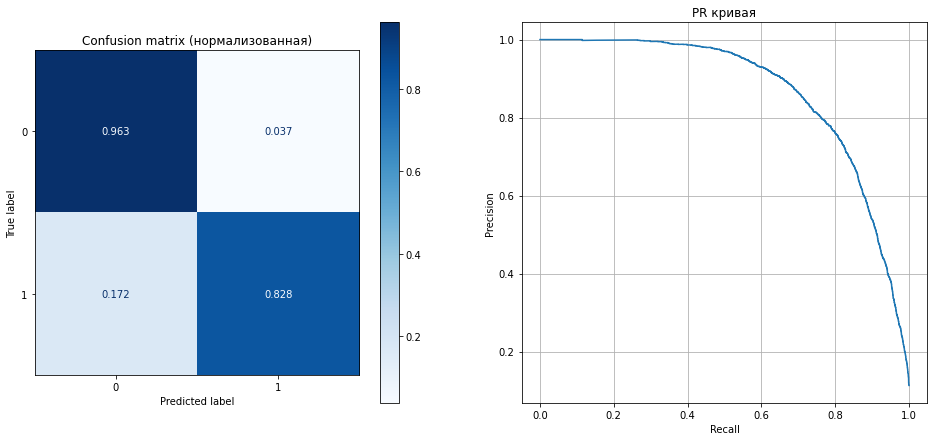

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
#готовим confusion matrix
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_predicted, normalize='true')
)
cmd.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='.3f')
ax[0].set_title('Confusion matrix (нормализованная)')
#готовим PR кривую
precision, recall, threshold = precision_recall_curve(
    y_test, 
    search.predict_proba(X_test)[:,1]
)
ax[1].plot(recall, precision)
ax[1].grid(True)
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('Recall')
ax[1].set_title('PR кривая')
#визуализируем
fig.show()

Зафиксируем наблюдения: 
 - доли истинно-положительных (TP) и истинно-отрицательных (TN) прогнозов довольно велики: TP = 0.828, TN = 0.963; 
 - доля ложно-положительных (FP) прогнозов на порядок ниже доли ложно-отрицательных (FN): FP = 0.037, FN = 0.172. 

Следовательно, модель хорошо классифицирует комментарии, заметно лучше распознавая нетоксичные. Вероятно, это последствия дисбаланса классов. При необходимости более точного прогноза, можно дополнительно компенсировать дисбаланс, подобрав порог классификации (threshold). 
## Выводы
**В ходе обзора и подготовки данных** ([см.3](#%D0%9E%D0%B1%D0%B7%D0%BE%D1%80-%D0%B8-%D0%BF%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)):
 - удален неинформативный признак,
 - показан дисбаланс классов.

**В ходе конструирования признаков** ([см.4](#%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2)):
 - сформирован корпус лемматизированных, очищенных текстов, 
 - добавлены признаки `word_count` (кол-во слов в комментарии) и `char_count` (кол-во символов в комментарии). 

**При формирования выборок**, в соотношении 0.75/0.25, созданы стратифицированные обучающая и тестовая выборки ([см.5](#%D0%A4%D0%BE%D1%80%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BE%D0%BA)).

**В ходе моделирования** на обучающей выборке с кроссвалидацией и метрикой F1 ([см.6](#%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)):
 - сформированы векторы признаков TF-IDF,
 - масштабированы признаки `word_count` и `char_count`,
 - проведен поиск гиперпараметров для моделей:
     - LogisticRegression,
     - SGDClassifier,
     - CatBoostClassifier.

**В ходе сравнения** показано, что LogisticRegression ([см.7](#%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9)):
 - является лучшей моделью по критерию F1 на обучающей выборке,
 - имеет F1 выше контрольного значения 0.75 на тестовой выборке.